## Libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.9.1


In [4]:
import pathlib
data_dir = pathlib.Path("/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray") 
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
print(image_count)

5856


## Load data

In [5]:
# Create the function to get the images with their label

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [5]:
# Get the data

train_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/train')
test_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/test')
val_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/val')

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data visualization & preprocessing

In [6]:
train_ds.shape

(4416, 2)

<AxesSubplot:ylabel='count'>

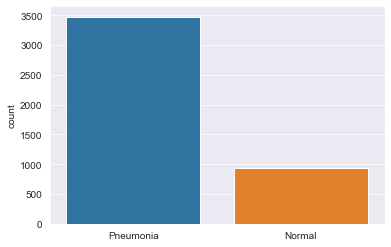

In [7]:
# Count images for each case

l = []
for i in train_ds:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'NORMAL')

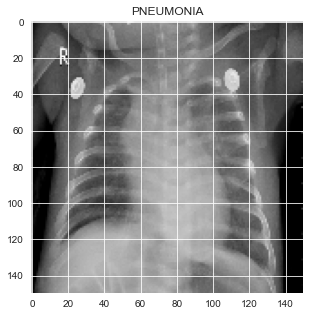

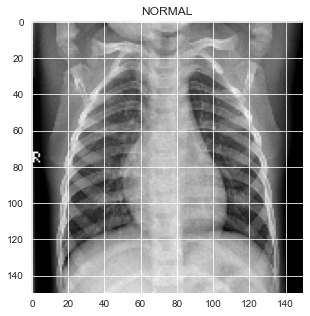

In [8]:
# Preview of two images

plt.figure(figsize = (5,5))
plt.imshow(train_ds[0][0], cmap='gray')
plt.title(labels[train_ds[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_ds[-1][0], cmap='gray')
plt.title(labels[train_ds[-1][1]])

In [9]:
# Create a list of the (value, label) in form of arrays

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_ds:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_ds:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_ds:
    x_val.append(feature)
    y_val.append(label)

In [10]:
# Normalize the data

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [11]:
x_train.shape

(4416, 150, 150)

In [12]:
# Resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
x_train.shape

(4416, 150, 150, 1)

## Data augmentation

#### In order to avoid overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations. 

In [14]:
datagen = ImageDataGenerator(
    
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False)  # randomly flip images


datagen.fit(x_train)

## Model

### CNN

In [6]:
model = Sequential()

model.add(Conv2D(16 , (3,3) , strides = 1, activation = 'relu', 
                 input_shape = (150,150,1)))
model.add(MaxPool2D())

model.add(Conv2D(32 , (3,3) , strides = 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16 , (3,3) , strides = 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

#model.add(Conv2D(32 , (3,3) , strides = 1, activation = 'relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units = 64 , activation = 'relu',
                activity_regularizer=regularizers.L2(1e-4)
               ))
model.add(Dropout(0.3))

model.add(Dense(units = 1 , activation = 'sigmoid'))

2022-07-10 13:07:15.856890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
epochs = 100
batch_size = 32

opt = keras.optimizers.Adam()

model.compile(optimizer = opt,
              loss = tf.losses.BinaryCrossentropy(),
              metrics = ['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
                        ])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', #learning rate reduction
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.32, 
                                            min_lr=0.0000001)


logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)  #savings logs

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True) #early stopping

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                        

### Training

In [18]:
hist = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size), 
                epochs = epochs, 
                validation_data = datagen.flow(x_val, y_val),
                callbacks = [tensorboard_callback,learning_rate_reduction]
                )

Epoch 1/100
138/138 [==============================] - 78s 554ms/step - loss: 0.3906 - accuracy: 0.8519 - precision: 0.6648 - recall: 0.6153 - val_loss: 2.2628 - val_accuracy: 0.5762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 74s 533ms/step - loss: 0.3031 - accuracy: 0.8779 - precision: 0.7243 - recall: 0.6897 - val_loss: 6.6280 - val_accuracy: 0.5762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8965 - precision: 0.7591 - recall: 0.7535
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00032000001519918444.
138/138 [==============================] - 68s 489ms/step - loss: 0.2740 - accuracy: 0.8965 - precision: 0.7591 - recall: 0.7535 - val_loss: 9.9254 - val_accuracy: 0.5762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/100
138/138 [==============================] -

138/138 [==============================] - 68s 490ms/step - loss: 0.1914 - accuracy: 0.9364 - precision: 0.8511 - recall: 0.8502 - val_loss: 0.3711 - val_accuracy: 0.8730 - val_precision: 0.9691 - val_recall: 0.7235 - lr: 1.0000e-07
Epoch 61/100
138/138 [==============================] - 63s 456ms/step - loss: 0.1816 - accuracy: 0.9370 - precision: 0.8545 - recall: 0.8491 - val_loss: 0.3729 - val_accuracy: 0.8672 - val_precision: 0.9571 - val_recall: 0.7189 - lr: 1.0000e-07
Epoch 62/100
138/138 [==============================] - 64s 463ms/step - loss: 0.1774 - accuracy: 0.9434 - precision: 0.8719 - recall: 0.8608 - val_loss: 0.3551 - val_accuracy: 0.8721 - val_precision: 0.9779 - val_recall: 0.7143 - lr: 1.0000e-07
Epoch 63/100
138/138 [==============================] - 75s 540ms/step - loss: 0.1959 - accuracy: 0.9364 - precision: 0.8548 - recall: 0.8448 - val_loss: 0.3730 - val_accuracy: 0.8672 - val_precision: 0.9686 - val_recall: 0.7097 - lr: 1.0000e-07
Epoch 64/100
138/138 [=======

In [19]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


13/13 [==============================] - 2s 132ms/step - loss: 0.2212 - accuracy: 0.9351 - precision: 0.9289 - recall: 0.9423
Loss of the model is -  0.22123439610004425
13/13 [==============================] - 2s 128ms/step - loss: 0.2212 - accuracy: 0.9351 - precision: 0.9289 - recall: 0.9423
Accuracy of the model is -  93.50961446762085 %


### Analysis

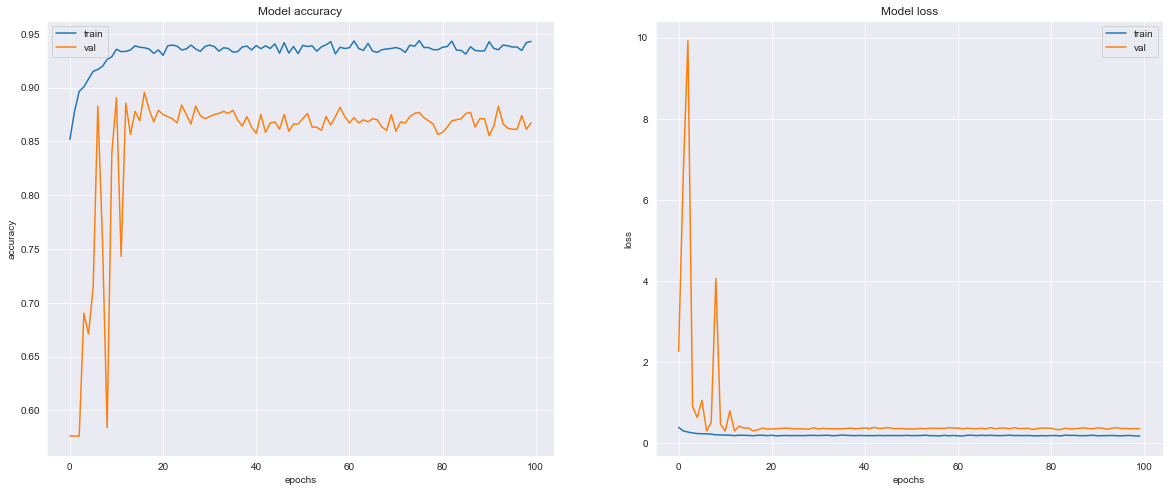

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

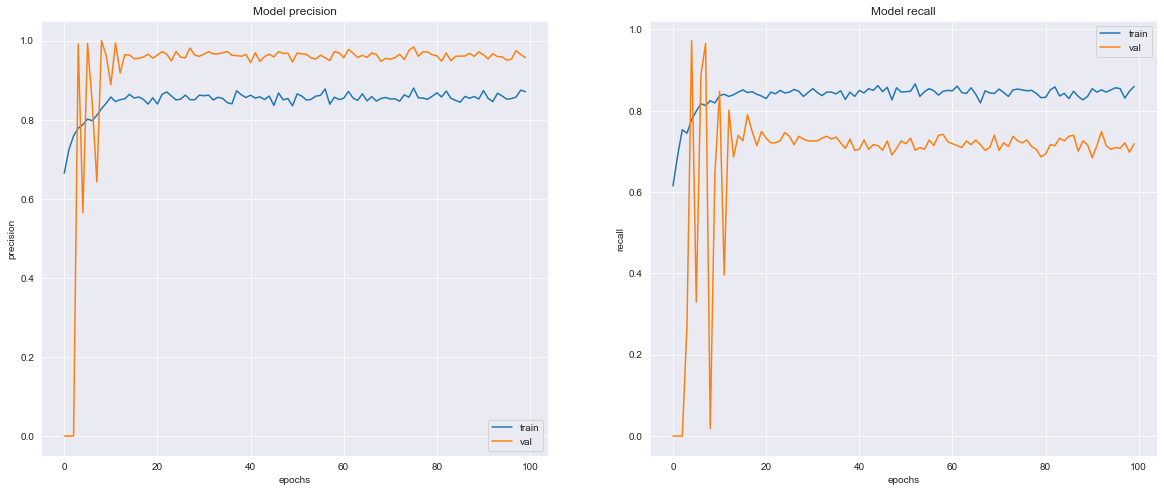

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]

13/13 [==============================] - 2s 128ms/step


In [23]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.93      0.93       208
   Normal (Class 1)       0.93      0.94      0.94       208

           accuracy                           0.94       416
          macro avg       0.94      0.94      0.94       416
       weighted avg       0.94      0.94      0.94       416



In [24]:
cm = confusion_matrix(y_test,predictions)
cm

array([[193,  15],
       [ 12, 196]])

<AxesSubplot:>

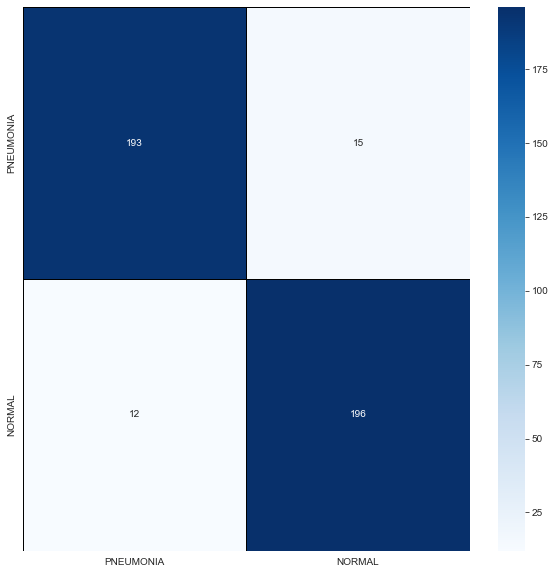

In [25]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)